In [1]:
# Analysis of Retirement with Mutual Funds
# Analysis period from 2000 Jan to 2020 May

#Importing libraries
import numpy as np  # useful for many scientific computing in Python
import pandas as pd # primary data structure library

In [2]:
# install xlrd to read spreadsheets
!pip install xlrd
import xlrd
print('xlrd installed!')

xlrd installed!


In [3]:
# reading excel file into data frame
df_data = pd.read_excel('nav_history.xlsx',
                       sheet_name='Sheet1')

print ('Data read into a pandas dataframe!')

Data read into a pandas dataframe!


In [4]:
# checking data frame
df_data.head()

,Date,Liquid Fund – NAV,Equity Fund – NAV
0,"Jan 03, 2000",12.760,24.91
1,"Feb 01, 2000",12.930,25.57
2,"Mar 01, 2000",13.120,27.74
3,"Apr 03, 2000",13.224,24.13
4,"May 02, 2000",13.330,20.78


In [5]:
# view df details
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245 entries, 0 to 244
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               245 non-null    object 
 1   Liquid Fund – NAV  245 non-null    float64
 2   Equity Fund – NAV  245 non-null    float64
dtypes: float64(2), object(1)
memory usage: 5.9+ KB


In [6]:
# Initial monthly income at 2000 Jan 1 is set to ₹13,000. Reason: at 7% inflation, ₹13,000 ~ ₹50,000 as on 2020
# Initial investment is set so that total withdrawal per year is 4% of capital. in this case ₹39 Lakhs
# Asset allocation is set to 60% Equity and 40% Debt

init_inv=3900000 # initial capital
init_eq_per=0.6
init_eq=init_inv*init_eq_per
init_dt=init_inv-init_eq

monthly_income=[] # creating a list for storing monthy income for every year
retirement_portfolio=[] # creating a list for storing retirement portfolio valuation every year
year=[] # creating a list for year value
year_num=0 # to track year in progress
monthly_income.append(13000) # initial monthly withdrawal
retirement_portfolio.append(init_inv) # initial portfolio valuation
year.append(2000) # initial year is 2000

In [7]:

# adding 6 new empty columns
df_data['Liquid fund – Units']=""
df_data['Equity fund – Units']=""
df_data['Redemption']=""
df_data['Liquid fund – Value']=""
df_data['Equity fund – Value']=""
df_data['Equity percent']=""

#initializing first row
df_data.loc[0,'Liquid fund – Units']=(init_dt-monthly_income[year_num])/df_data.loc[0,'Liquid Fund – NAV']
df_data.loc[0,'Equity fund – Units']=init_eq/df_data.loc[0,'Equity Fund – NAV']
df_data.loc[0,'Redemption']=monthly_income[year_num]
df_data.loc[0,'Liquid fund – Value']=df_data.loc[0,'Liquid fund – Units']*df_data.loc[0,'Liquid Fund – NAV']
df_data.loc[0,'Equity fund – Value']=df_data.loc[0,'Equity fund – Units']*df_data.loc[0,'Equity Fund – NAV']
df_data.loc[0,'Equity percent']=(100*df_data.loc[0,'Equity fund – Value'])/(df_data.loc[0,'Equity fund – Value']+df_data.loc[0,'Liquid fund – Value'])

# number of rows
var_rows=len(df_data.index)

for i in range(1,var_rows):
    if(i%12==0): # when 1 year is completed, asset rebalance is triggered
        year_num+=1 # incrementing year number
        year.append(2000+year_num)
        # calculating asset allocation before redemption and rebalancing
        df_data.loc[i,'Liquid fund – Units']=df_data.loc[i-1,'Liquid fund – Units']
        df_data.loc[i,'Equity fund – Units']=df_data.loc[i-1,'Equity fund – Units']
        df_data.loc[i,'Liquid fund – Value']=df_data.loc[i,'Liquid fund – Units']*df_data.loc[i,'Liquid Fund – NAV']
        df_data.loc[i,'Equity fund – Value']=df_data.loc[i,'Equity fund – Units']*df_data.loc[i,'Equity Fund – NAV']
        total_value=df_data.loc[i,'Liquid fund – Value']+df_data.loc[i,'Equity fund – Value']
        df_data.loc[i,'Equity percent']=(100*df_data.loc[i,'Equity fund – Value'])/total_value
        retirement_portfolio.append(total_value) # storing portfolio valuation yearly during rebalancing
        # if equity exceeds 60%
        if(df_data.loc[i,'Equity percent']>60):
            # equity is above 60%, moving excess equity asset into liquid fund to bring back asset allocation to 60:40
            excess_equity=df_data.loc[i,'Equity fund – Value']-(0.6*total_value)
            df_data.loc[i,'Liquid fund – Units']=df_data.loc[i,'Liquid fund – Units']+(excess_equity/df_data.loc[i,'Liquid Fund – NAV'])
            df_data.loc[i,'Equity fund – Units']=df_data.loc[i,'Equity fund – Units']-(excess_equity/df_data.loc[i,'Equity Fund – NAV'])
            df_data.loc[i,'Liquid fund – Value']=df_data.loc[i,'Liquid fund – Units']*df_data.loc[i,'Liquid Fund – NAV']
            df_data.loc[i,'Equity fund – Value']=df_data.loc[i,'Equity fund – Units']*df_data.loc[i,'Equity Fund – NAV']
        # Finding new monthly withdrawal
        monthly_income.append(df_data.loc[i,'Liquid fund – Value']/120) # 10% of liquid fund value is redeemed an year
        df_data.loc[i,'Redemption']=monthly_income[year_num]
        # recording updated liquid fund units, value and equity percentage after 1 month withdrawal
        df_data.loc[i,'Liquid fund – Units']=df_data.loc[i,'Liquid fund – Units']-(monthly_income[year_num]/df_data.loc[i,'Liquid Fund – NAV'])
        df_data.loc[i,'Liquid fund – Value']=df_data.loc[i,'Liquid fund – Units']*df_data.loc[i,'Liquid Fund – NAV']
        df_data.loc[i,'Equity percent']=(100*df_data.loc[i,'Equity fund – Value'])/(df_data.loc[i,'Equity fund – Value']+df_data.loc[i,'Liquid fund – Value'])
        
    else:
        # months without rebalacing. only redemption from liquid funds is carried out
        df_data.loc[i,'Liquid fund – Units']=df_data.loc[i-1,'Liquid fund – Units']-(monthly_income[year_num]/df_data.loc[i,'Liquid Fund – NAV'])
        df_data.loc[i,'Equity fund – Units']=df_data.loc[i-1,'Equity fund – Units']
        df_data.loc[i,'Redemption']=monthly_income[year_num]
        df_data.loc[i,'Liquid fund – Value']=df_data.loc[i,'Liquid fund – Units']*df_data.loc[i,'Liquid Fund – NAV']
        df_data.loc[i,'Equity fund – Value']=df_data.loc[i,'Equity fund – Units']*df_data.loc[i,'Equity Fund – NAV']
        df_data.loc[i,'Equity percent']=(100*df_data.loc[i,'Equity fund – Value'])/(df_data.loc[i,'Equity fund – Value']+df_data.loc[i,'Liquid fund – Value'])
    #end else
#end for

In [8]:
# import required libraries for graph plot
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
print ('Matplotlib version: ', mpl.__version__ )

# choosing plot style
print(plt.style.available)
mpl.style.use(['ggplot'])


Matplotlib version:  3.1.3
['seaborn-paper', 'seaborn-talk', 'seaborn-whitegrid', 'bmh', 'seaborn-pastel', 'tableau-colorblind10', 'seaborn-bright', 'seaborn-notebook', 'seaborn-colorblind', 'fivethirtyeight', 'seaborn-ticks', 'seaborn-darkgrid', 'seaborn', 'seaborn-poster', 'dark_background', 'seaborn-muted', 'fast', 'grayscale', '_classic_test', 'Solarize_Light2', 'seaborn-dark-palette', 'seaborn-white', 'seaborn-dark', 'seaborn-deep', 'ggplot', 'classic']


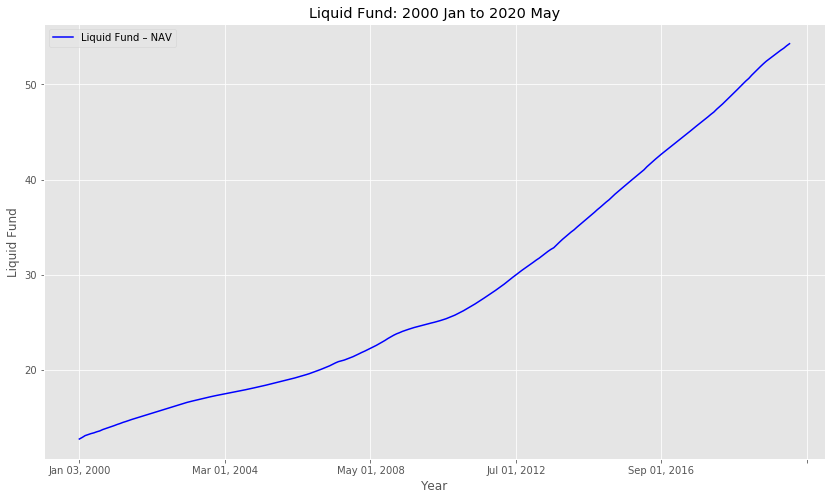

In [9]:
# Graph to plot liquid fund NAV

# creating new dataframe graphdf with 2 columns Date and Nifty
graphdf=df_data[['Date','Liquid Fund – NAV']]

# plotting the line chart with 'Date' as X axis
graphdf.set_index('Date').plot(kind='line',figsize=(14,8),color='blue')
plt.title('Liquid Fund: 2000 Jan to 2020 May')
plt.xlabel('Year')
plt.ylabel('Liquid Fund')
plt.savefig('pic01.png')
plt.show()

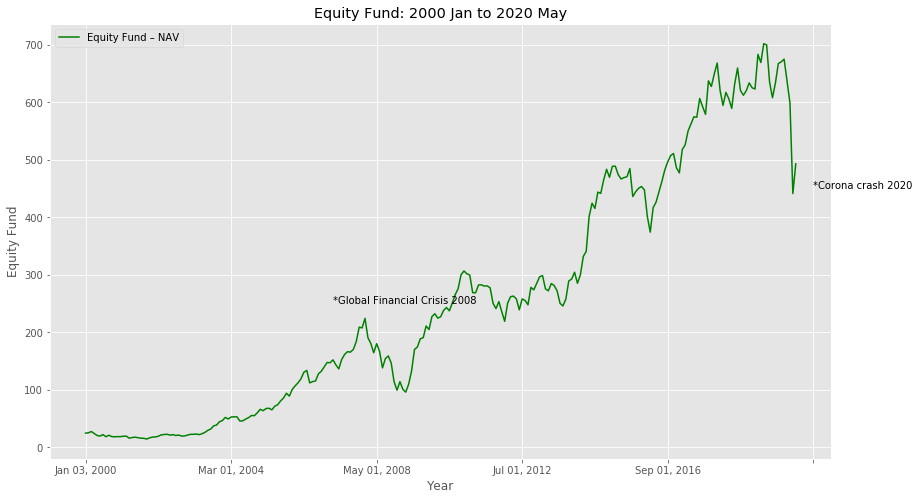

In [10]:
# Graph to plot Equity fund NAV

# creating new dataframe graphdf with 2 columns Date and Nifty
graphdf=df_data[['Date','Equity Fund – NAV']]

# plotting the line chart with 'Date' as X axis
graphdf.set_index('Date').plot(kind='line',figsize=(14,8),color='green')
plt.title('Equity Fund: 2000 Jan to 2020 May')
plt.xlabel('Year')
plt.ylabel('Equity Fund')
plt.text(85,250,'*Global Financial Crisis 2008')
plt.text(250,450,'*Corona crash 2020')
plt.savefig('pic02.png')
plt.show()

In [13]:
portfolio = pd.DataFrame(year,monthly_income,retirement_portfolio, colmuns=)

[2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020]